# 5. BRP and PLD Signal Processing

**Objective:** Develop a structured workflow to load, align, and merge the primary signals from the `_BRP.edf` and `_PLD.edf` files. This notebook moves from exploration to creating a reusable data processing pipeline for feature engineering.

## 5.1 Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import mne
from IPython.display import display, Markdown

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_loader import load_edf_data

# Configure plotting
plt.rcParams['figure.figsize'] = (20, 8)
pd.set_option('display.max_rows', 100)

## 5.2 Data Loading and Merging Function

This function encapsulates the logic for processing a single sleep study session. It finds the relevant `BRP` and `PLD` files, loads them, selects the essential signals, and merges them into a single, time-aligned DataFrame.

In [2]:
def load_and_merge_session_data(base_path, session_timestamp):
    """
    Loads, cleans, and merges BRP and PLD data for a specific session.

    Args:
        base_path (str): The directory containing the data files.
        session_timestamp (str): The timestamp identifier for the session (e.g., '20250617_023551').

    Returns:
        pd.DataFrame: A merged DataFrame containing the relevant signals,
                      or None if essential files are not found.
    """
    file_paths = {
        'BRP': os.path.join(base_path, f"{session_timestamp}_BRP.edf"),
        'PLD': os.path.join(base_path, f"{session_timestamp}_PLD.edf")
    }

    # Check for file existence
    if not os.path.exists(file_paths['BRP']) or not os.path.exists(file_paths['PLD']):
        print(f"Error: Data files for session {session_timestamp} not found.")
        return None

    # Load BRP data and select the 'Flow' signal
    df_brp = load_edf_data(file_paths['BRP'])
    if df_brp is None or 'Flow.40ms' not in df_brp.columns:
        print(f"Error: 'Flow.40ms' not found in {file_paths['BRP']}")
        return None
    df_flow = df_brp[['Flow.40ms']].copy()

    # Load PLD data
    df_pld = load_edf_data(file_paths['PLD'])
    if df_pld is None:
        print(f"Error: Could not load data from {file_paths['PLD']}")
        return None
        
    # Clean PLD data by removing checksum columns
    cols_to_drop = [c for c in df_pld.columns if 'Crc' in c]
    df_pld.drop(columns=cols_to_drop, inplace=True)

    # Merge the dataframes
    # We use an outer join and forward-fill to handle potential minor misalignments
    # in timestamps between the two files.
    merged_df = pd.merge(df_flow, df_pld, left_index=True, right_index=True, how='outer')
    merged_df.ffill(inplace=True)
    merged_df.dropna(inplace=True) # Drop any remaining NaNs at the beginning

    print(f"Successfully loaded and merged data for session {session_timestamp}")
    return merged_df

## 5.3 Process a Sample Session

Let's test the function with a sample session and inspect the resulting DataFrame.

In [3]:
# --- Configuration ---
DATA_DIR = '../data/2025/'
SESSION_ID = '20250617_023551' # Using the same session from the previous notebook

# --- Processing ---
session_df = load_and_merge_session_data(DATA_DIR, SESSION_ID)

if session_df is not None:
    display(Markdown("### Merged DataFrame Info"))
    session_df.info()
    display(Markdown("### Merged DataFrame Head"))
    display(session_df.head())

Successfully loaded and merged data for session 20250617_023551


### Merged DataFrame Info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 526500 entries, 2025-06-17 02:35:51+00:00 to 2025-06-17 08:26:50.960000+00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Flow.40ms     526500 non-null  float64
 1   MaskPress.2s  526500 non-null  float64
 2   Press.2s      526500 non-null  float64
 3   EprPress.2s   526500 non-null  float64
 4   Leak.2s       526500 non-null  float64
 5   RespRate.2s   526500 non-null  float64
 6   TidVol.2s     526500 non-null  float64
 7   MinVent.2s    526500 non-null  float64
 8   Snore.2s      526500 non-null  float64
 9   FlowLim.2s    526500 non-null  float64
dtypes: float64(10)
memory usage: 44.2 MB


### Merged DataFrame Head

,Flow.40ms,MaskPress.2s,Press.2s,EprPress.2s,Leak.2s,RespRate.2s,TidVol.2s,MinVent.2s,Snore.2s,FlowLim.2s
timestamp,,,,,,,,,,
2025-06-17 02:35:51+00:00,656000.0,800000.0,4260000.0,4000000.0,120000.0,0.0,0.0,0.0,0.0,-10000.0
2025-06-17 02:35:51.040000+00:00,692000.0,800000.0,4260000.0,4000000.0,120000.0,0.0,0.0,0.0,0.0,-10000.0
2025-06-17 02:35:51.080000+00:00,720000.0,800000.0,4260000.0,4000000.0,120000.0,0.0,0.0,0.0,0.0,-10000.0
2025-06-17 02:35:51.120000+00:00,742000.0,800000.0,4260000.0,4000000.0,120000.0,0.0,0.0,0.0,0.0,-10000.0
2025-06-17 02:35:51.160000+00:00,756000.0,800000.0,4260000.0,4000000.0,120000.0,0.0,0.0,0.0,0.0,-10000.0


## 5.4 Visualization

Plot the merged signals to visually confirm that the alignment is correct.

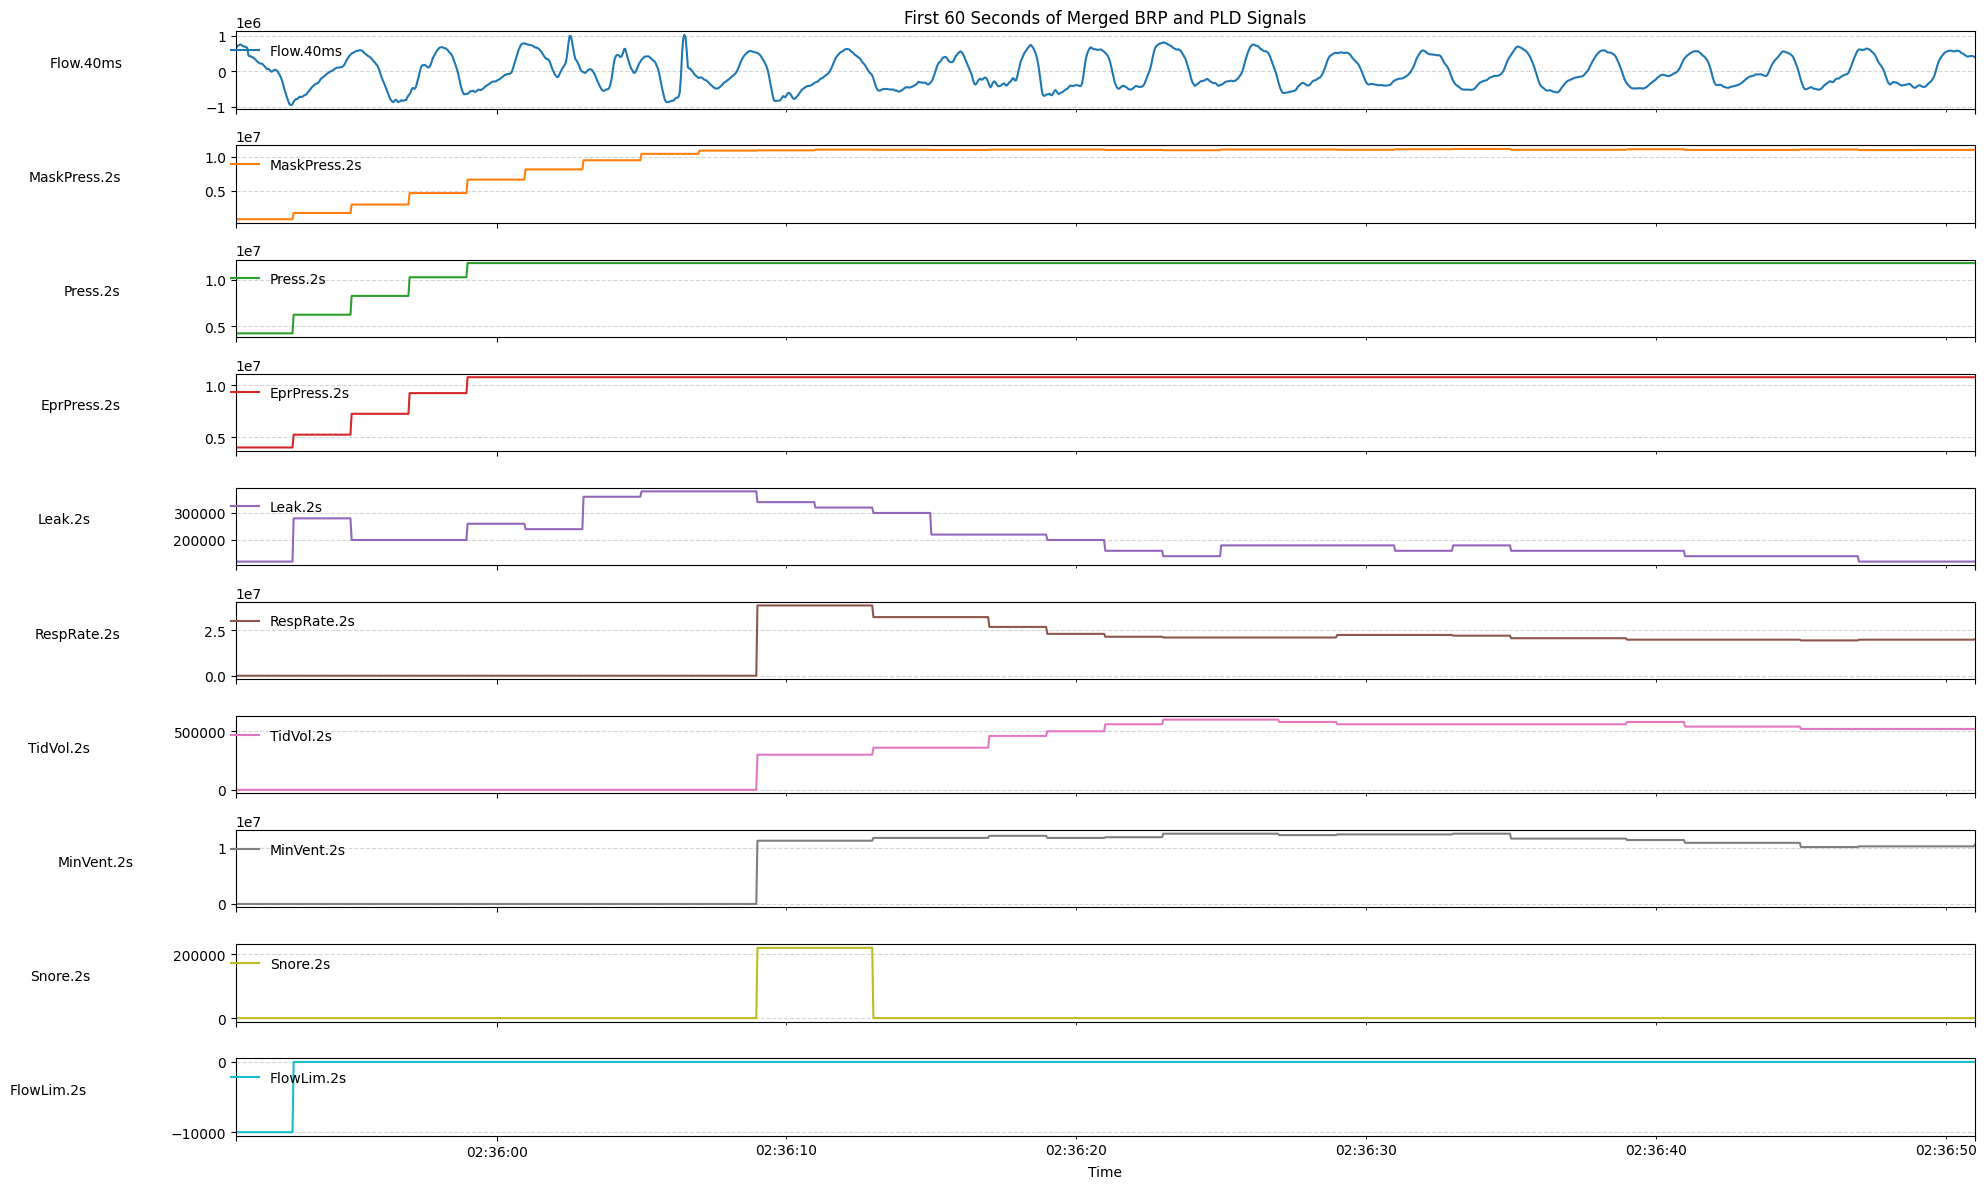

In [7]:
if session_df is not None:
    # Plot the first 60 seconds of the data
    plot_duration_s = 60
    plot_end_time = session_df.index.min() + pd.Timedelta(seconds=plot_duration_s)
    plot_data = session_df.loc[session_df.index.min():plot_end_time]

    axes = plot_data.plot(
        subplots=True,
        figsize=(20, 12),
        sharex=True,
        legend=False  # We'll add custom legends/labels
    )

    for ax, col in zip(axes, plot_data.columns):
        ax.set_ylabel(col, rotation=0, labelpad=60, ha='right', va='center')
        ax.yaxis.set_label_position("left")
        ax.legend([col], loc='upper left', bbox_to_anchor=(-0.01, 1.0), frameon=False)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    axes[0].set_title(f'First {plot_duration_s} Seconds of Merged BRP and PLD Signals')
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()